# Rotor Tracking Notebook 
Feb 2025

In [27]:
# Installing dependencies
import numpy as np
import cv2
from matplotlib import pyplot as plt
import trackpy as tp
import pandas as pd
import matplotlib.cm as cm
import os
import math

## 1. Config

In [28]:
# Config per video:
file_name = "1T1dot_50rpm_1.mp4" # eg. abcde.mp4
num_rotor = 2 # Number of rotors in video
size_thresh = 8 # default 8: minimum size for a dot to count as a rotor (higher is larger)
brightness_threshold=100 # default 100: minimum brightness for a dot to count as a rotor (higher is brighter)
memory = 10    # default 10:  number of frames a particle can disappear and still be considered the same
frame_thresh = 100 # number of frames a particle have to appear more than or else will be filtered
search_range = 15 # default 15: maximum movement a dot can have between frames
debug_mode = False # Set to False for faster running, True for seeing more intermedate steps

In [29]:
# Fixed Config, specifies output folder.
data_folder = "video_sample"
processed_data_folder = f"processed_video_sample"
if not os.path.exists(processed_data_folder): os.makedirs(processed_data_folder)
result_folder = f"result"
result_video_folder = os.path.join(result_folder,"annotated_video")
if not os.path.exists(result_video_folder): os.makedirs(result_video_folder)
result_csv_folder = os.path.join(result_folder,"csv")
if not os.path.exists(result_csv_folder): os.makedirs(result_csv_folder)

target video file exists at file_path='video_sample/1T1dot_50rpm_1.mp4'
num_frames=2500, width=1024, height=1024, fps=30.0


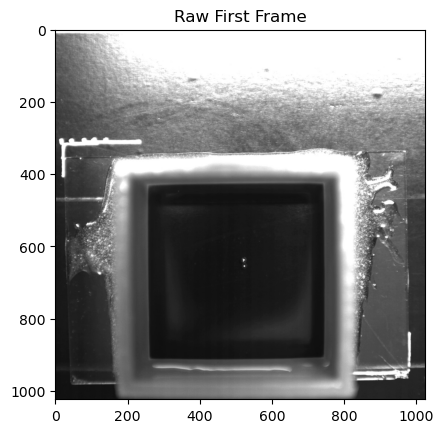

Note the x,y range you'd like to keep


In [30]:
# Load the video
file_path = os.path.join(data_folder,file_name)
if os.path.exists(file_path):
    print(f"target video file exists at {file_path=}")
else:
    raise Exception(f"File not found at {file_path}")
cap = cv2.VideoCapture(file_path)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
print(f"{num_frames=}, {width=}, {height=}, {fps=}")

ret, frame = cap.read()
if ret:
    plt.imshow(frame)
    plt.title("Raw First Frame")
    plt.axis('on')
    plt.show()
    print("Note the x,y range you'd like to keep")
else:
    print("Error: Couldn't read the first frame.")


In [31]:
x_left = 400
x_right = 650
y_up = 500
y_bot = 750
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
x_crop_size = x_right-x_left
y_crop_size = y_bot - y_up
processed_file_path = os.path.join(processed_data_folder,f"processed_{file_name}")
print(f"gray scaled & cropped video would be saved in {processed_file_path}")
out = cv2.VideoWriter(processed_file_path, fourcc, fps, (x_crop_size, y_crop_size), isColor=True)
cap = cv2.VideoCapture(file_path)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    cropped = frame[y_up:y_bot, x_left:x_right]
    out.write(cropped)
cap.release()
out.release()
print("done!")

gray scaled & cropped video would be saved in processed_video_sample/processed_1T1dot_50rpm_1.mp4
done!


In [32]:
frame_num = 0
features = pd.DataFrame(columns=['x', 'y', 'frame'])
cap = cv2.VideoCapture(processed_file_path)
unexpected_rotor_frame_count=0

while True:
    # Read the frame
    ret, frame = cap.read()
    if not ret: break
    else: frame_num += 1
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, brightness_threshold, 255, cv2.THRESH_BINARY)
    thresh = cv2.GaussianBlur(thresh, (3, 3), 0)
    thresh = cv2.erode(thresh,np.ones((2,2),np.uint8),iterations=1)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh)
    
    # Iterate through each component and find the centroid
    rotor_count_in_frame = 0
    for i in range(1, num_labels):
        # Check if the size of the component is greater than the threshold
        size_i = stats[i, cv2.CC_STAT_AREA]
        if stats[i, cv2.CC_STAT_AREA] > size_thresh:
            cx = int(centroids[i][0])
            cy = int(centroids[i][1])
            features = pd.concat([features,pd.DataFrame({'x': [cx], 'y': [cy], 'frame': [frame_num]})],ignore_index=True)
            if debug_mode:
                # Draw a hollow circle at each centroid
                cv2.circle(frame, (cx, cy), 5, (0, 0, 255), thickness=1, lineType=cv2.LINE_AA)
            rotor_count_in_frame += 1
    if rotor_count_in_frame != num_rotor:
        unexpected_rotor_frame_count += 1
        if debug_mode:
            print(f'Found {rotor_count_in_frame} rotors in frame {frame_num}')
            print("press any key to see next frame, q to force quit")
            cv2.imshow('frame', frame)
            cv2.waitKey(0)
    print(f"Progress: Frame {frame_num} / {num_frames}", flush=True, end='\r')
print(f"Done, with {unexpected_rotor_frame_count}/{num_frames} frames having num_rotors != {num_rotor}")

# Release the video and close all windows
cap.release()
cv2.destroyAllWindows()

Done, with 0/2500 frames having num_rotors != 2


In [33]:
features.head(2)

,x,y,frame
0,122,139,1
1,124,156,1


In [34]:
trajectories = tp.link_df(features, search_range=search_range, memory=memory)
particle_counts = trajectories['particle'].value_counts() # Count the occurrences of each particle
valid_particles = particle_counts[particle_counts >= frame_thresh].index # Filter out particles that appear fewer than frame_thresh times
filtered_trajectories = trajectories[trajectories['particle'].isin(valid_particles)]
print(f"raw result contains {len(particle_counts)} particles, {len(valid_particles)} of which appeared in more then {frame_thresh} frames")

# Sort particles by their frequency of appearance in descending order
particle_sorted = particle_counts[particle_counts >= frame_thresh].sort_values(ascending=False)
# Create a mapping from old particle IDs to new sorted IDs
new_particle_ids = {old_id: new_id + 1 for new_id, old_id in enumerate(particle_sorted.index)}
filtered_trajectories["particle"] = filtered_trajectories['particle'].map(new_particle_ids)
filtered_trajectories.sort_values(by=["frame","particle"],inplace=True,ignore_index=True)

if debug_mode:
    display(filtered_trajectories.head())
    print(filtered_trajectories.columns)

Frame 2500: 2 trajectories present.
raw result contains 2 particles, 2 of which appeared in more then 100 frames


In [35]:
# # Config
# merge_distance_threshold = 10  # pixels
# prop_thresh = 0.8              # threshold proportion for merging

# # Ensure valid_particles is a list of valid particle IDs.
# valid_particles = list(valid_particles)

# # Setup union-find structure.
# parent = {p: p for p in valid_particles}

# def find(p):
#     if p not in parent:
#         return p  # or handle this case differently as needed
#     while parent[p] != p:
#         parent[p] = parent[parent[p]]
#         p = parent[p]
#     return p

# def union(a, b):
#     root_a = find(a)
#     root_b = find(b)
#     if root_a != root_b:
#         parent[root_b] = root_a

# # Iterate over all pairs of valid particles.
# for i in range(len(valid_particles)):
#     for j in range(i + 1, len(valid_particles)):
#         particle_i = valid_particles[i]
#         particle_j = valid_particles[j]
        
#         # Extract trajectories for each particle.
#         temp_i = filtered_trajectories[filtered_trajectories['particle'] == particle_i]
#         temp_j = filtered_trajectories[filtered_trajectories['particle'] == particle_j]
        
#         # Merge on 'frame' to get only common frames.
#         temp_join = pd.merge(temp_i, temp_j, on="frame", suffixes=('_i', '_j'))
#         if temp_join.empty:
#             continue
#         temp_join["distance"]=((temp_join['x_i']-temp_join['x_j'])**2+(temp_join['y_i']-temp_join['y_j'])**2)**0.5
#         # Compute the proportion of frames with distance below the threshold.
#         prop_close = np.mean(temp_join["distance"] < merge_distance_threshold)
        
#         if prop_close > prop_thresh:
#             print(f"particle {i}, particle {j}should be merged")
#             union(particle_i, particle_j)

# # Remap the particle IDs in filtered_trajectories based on union-find groups.
# filtered_trajectories['particle'] = filtered_trajectories['particle'].apply(find)

# # Clean up: if a particle shows up multiple times in a frame, average its x and y.
# filtered_trajectories = filtered_trajectories.groupby(['frame', 'particle'], as_index=False).agg({'x': 'mean', 'y': 'mean'})

# # Print the number of unique particles after merging.
# unique_particles = filtered_trajectories['particle'].unique()
# num_particles = len(unique_particles)
# print(f"Number of unique particles after merging: {num_particles}")



In [36]:
unique_particles = filtered_trajectories['particle'].unique()
num_particles = len(unique_particles)
cmap = cm.get_cmap('viridis', num_particles)
color_map = {}
for idx, pid in enumerate(unique_particles):
    rgba = cmap(idx)
    rgb = tuple(int(255 * c) for c in rgba[:3])
    bgr = rgb[::-1]
    color_map[pid] = bgr

cap = cv2.VideoCapture(processed_file_path)
ret, frame = cap.read()

width = x_crop_size
height = y_crop_size

min_frame = int(filtered_trajectories['frame'].min())
max_frame = int(filtered_trajectories['frame'].max())

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_path = os.path.join(result_video_folder,file_name)
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for f in range(min_frame, max_frame + 1):
    ret, frame = cap.read()
    if not ret: break
    
    particles_frame = filtered_trajectories[filtered_trajectories['frame'] == f]
    
    # Draw each particle as a hollow square.
    for _, row in particles_frame.iterrows():
        x = int(row['x'])
        y = int(row['y'])
        particle_id = row['particle']
        color = color_map.get(particle_id, (255, 255, 255))  # defaults to white if not found
        
        # Define the size of the square: here, a square of 6x6 pixels centered at (x,y)
        half_diam = 4
        top_left = (x - half_diam, y - half_diam)
        bottom_right = (x + half_diam, y + half_diam)
        cv2.rectangle(frame, top_left, bottom_right, color, thickness=2)
    
    out.write(frame)

out.release()
cap.release()

/var/folders/ql/j7zs0n1150x82l4g24_b0jzm0000gn/T/ipykernel_7513/1108542458.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', num_particles)


In [37]:
csv_out_path = os.path.join(result_csv_folder,file_name)
filtered_trajectories.to_excel(csv_out_path+".xlsx", index=False)
filtered_trajectories.to_csv(csv_out_path+".csv", index=False)